# **Module 3: Raster Data in Python**
## Prerequisites
### Data
- in this example, we will create some raster data to imitate real-world data. We will use `data-module-3` as a workspace.
- `ndvi_summer.tif` and `ndvi_winter.tif` - Normalized Difference Vegetation Index (NDVI) for a study area in Kansas. NDVI is an indicator of vegetation health. Data exported from Climate Engine at http://climateengine.org.
- `ag_fields.shp` - selected agricultural fields for a study area in Kansas.
- 
### Software
To execute the code you will need a Python environment with the packages imported below. The default environment does not have all required packages to execute this script. Therefore, run the following command beforehand:
- `pip install xarray xarray-spatial --user`

In [1]:
# general use packages
import numpy as np
import matplotlib.pyplot as plt

# geospatial packages
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
from rasterio.transform import Affine
import rasterio.mask
from rasterstats import zonal_stats
from rasterio.plot import plotting_extent
from rasterio.enums import Resampling
import xarray as xr
from xrspatial.convolution import circle_kernel
from xrspatial.focal import focal_stats
from xrspatial.zonal import stats

## Create raster data
To generate raster data in Python we use on `numpy` and `rasterio` packages. We need the following three components:
- An array of data and the xy coordinates;
- A Coordinate Reference System;
- A transform defining the coordinate of the upper left hand corner of the array.

In [2]:
print ("Generate data")
ras_0 = np.zeros([6, 6])
ras_a = np.arange(1, 37).reshape(6, 6)
np.random.seed(0)
ras_b = np.random.randint(100, size=(6,6))

Generate data


Text(0.5, 1.0, 'ras_b (Random Integers)')

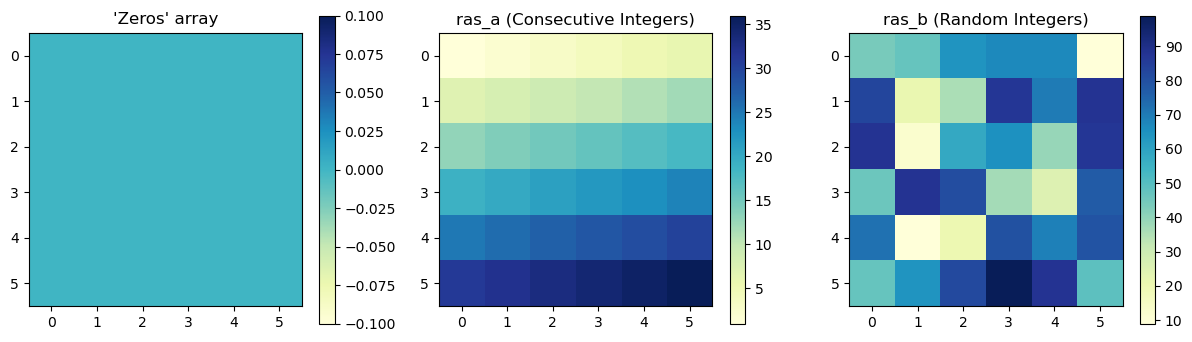

In [3]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
plot0 = axs[0].imshow(ras_0, cmap="YlGnBu")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("'Zeros' array")
plot1 = axs[1].imshow(ras_a, cmap="YlGnBu")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_a (Consecutive Integers)")
plot2 = axs[2].imshow(ras_b, cmap="YlGnBu")
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("ras_b (Random Integers)")

In [4]:
print ("Genarate arrays with coordinates")
x = np.linspace(-1.25, 1.25, 6)
y = np.linspace(-1.25, 1.25, 6)
X, Y = np.meshgrid(x, y)

Genarate arrays with coordinates


Text(0.5, 1.0, 'latitude')

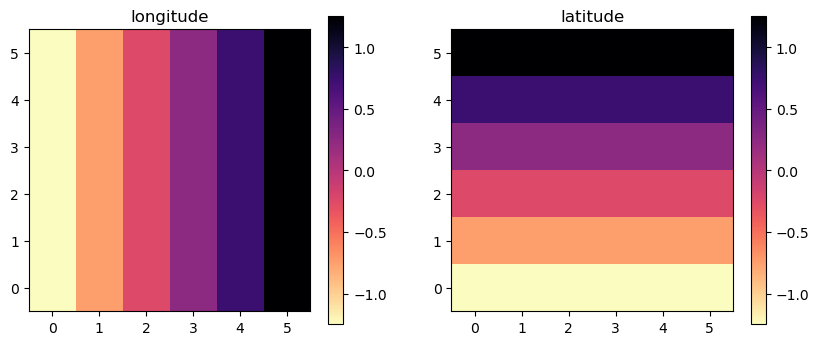

In [5]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
plot0 = axs[0].imshow(X, cmap="magma_r", origin="lower")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("longitude")
plot1 = axs[1].imshow(Y, cmap="magma_r",origin="lower")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("latitude")

In [6]:
print ("Define transform and save raster 'ras_a' to a file")
res = 0.5
transform = Affine.translation(x[0] - res / 2, -(y[0] - res / 2)) * Affine.scale(res, -res)
with rasterio.open("./data-module-3/ras_a.tif",
                   "w",
                   height=ras_a.shape[0],
                   width=ras_a.shape[1],
                   count=1,
                   dtype=np.int16,
                   crs="epsg:4326",
                   transform=transform,
                   nodata=-999
                  ) as dst:
     dst.write(ras_a, 1)

Define transform and save raster 'ras_a' to a file


## Read raster data from a file

In [7]:
ndvi_winter = rasterio.open("./data-module-3/ndvi_winter.tif")
ndvi_summer = rasterio.open("./data-module-3/ndvi_summer.tif")
print ("Dataset CRS is {}".format(ndvi_summer.crs))
print ("Dataset extent is {}".format(ndvi_summer.bounds))
print ("Dataset resolution is {}".format(ndvi_summer.res))
print ("Dataset NoData is {}".format(ndvi_summer.nodata))
print ("Dataset tranform is")
ndvi_summer.transform

Dataset CRS is EPSG:4326
Dataset extent is BoundingBox(left=-100.71605538351474, bottom=37.25250601173768, right=-100.51177848790597, top=37.45354897232363)
Dataset resolution is (0.000269494585235846, 0.0002694945852358598)
Dataset NoData is -9999.0
Dataset tranform is


Affine(0.000269494585235846, 0.0, -100.71605538351474,
       0.0, -0.0002694945852358598, 37.45354897232363)

In [8]:
ndvi_winter_array = ndvi_winter.read(1)
ndvi_winter_array[ndvi_winter_array==ndvi_winter.nodata] = np.nan
ndvi_summer_array = ndvi_summer.read(1)
ndvi_summer_array[ndvi_summer_array==ndvi_summer.nodata] = np.nan

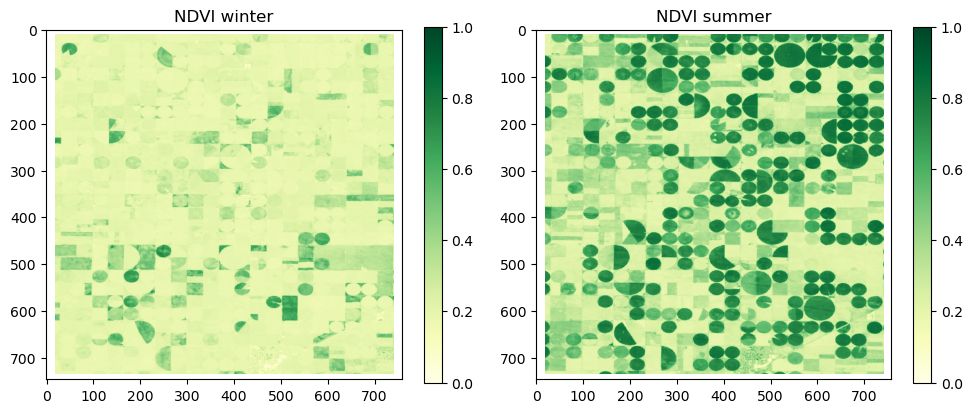

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
plot0 = axs[0].imshow(ndvi_winter_array, cmap="YlGn", clim=(0,1))
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("NDVI winter")
plot1 = axs[1].imshow(ndvi_summer_array, cmap="YlGn",  clim=(0,1))
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("NDVI summer")
plt.tight_layout()

## Describe raster data

Number of rows of raster b is 6
Number of colomns of raster b is 6
Number of cells of raster b is 36


(array([3., 3., 0., 4., 4., 1., 7., 4., 9., 1.]),
 array([ 9., 18., 27., 36., 45., 54., 63., 72., 81., 90., 99.]),
 <BarContainer object of 10 artists>)

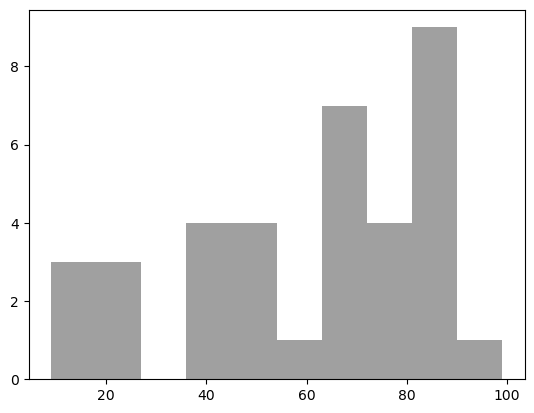

In [10]:
print ("Number of rows of raster b is {}".format(ras_b.shape[0]))
print ("Number of colomns of raster b is {}".format(ras_b.shape[1]))
print ("Number of cells of raster b is {}".format(ras_b.shape[0]*ras_b.shape[1]))
plt.hist(ras_b.flatten(), facecolor="grey", alpha=0.75)

In [11]:
print ("Raster unique values are: {}".format(np.unique(ras_b)))
print ("Get subsets of raster data")
print ("Value at position 0 col and 0 row {}".format(ras_b[0,0]))
print ("Value at position 2 col and 2 row {}".format(ras_b[2,2]))
print ("Array starting from 2 col and 2 row:")
print (ras_b[2:, 2:])

Raster unique values are: [ 9 12 20 21 25 36 37 39 44 46 47 49 58 64 65 67 69 70 72 77 79 80 81 82
 83 87 88 99]
Get subsets of raster data
Value at position 0 col and 0 row 44
Value at position 2 col and 2 row 58
Array starting from 2 col and 2 row:
[[58 65 39 87]
 [81 37 25 77]
 [20 80 69 79]
 [82 99 88 49]]


## Summarize raster data
Below we present some methods to summarize and describe array data with common statistics.

In [12]:
print ("Applying mean() function:")
print (np.mean(ras_a))
print ("Applying mean() function along axis 0:")
print (np.mean(ras_a, axis = 0)) 
print ("Applying mean() function along axis 1:")
print (np.mean(ras_a, axis = 1))
print ("Applying median() function:")
print (np.median(ras_a))
print ("Applying max() function:")
print (np.max(ras_a))
print ("Applying min() function:")
print (np.min(ras_a))
print ("Applying std() function:")
print (np.std(ras_a))
print ("Applying percentile() function:")
print (np.percentile(ras_a, 70))

Applying mean() function:
18.5
Applying mean() function along axis 0:
[16. 17. 18. 19. 20. 21.]
Applying mean() function along axis 1:
[ 3.5  9.5 15.5 21.5 27.5 33.5]
Applying median() function:
18.5
Applying max() function:
36
Applying min() function:
1
Applying std() function:
10.388294694831615
Applying percentile() function:
25.5


In [13]:
print ("Applying mean() function:")
print (np.mean(ndvi_summer_array))

Applying mean() function:
nan


In [14]:
print ("Applying nanmean() function:")
print (np.nanmean(ndvi_summer_array))
print ("Applying nanmedian() function:")
print (np.nanmedian(ndvi_summer_array))
print ("Applying nanmax() function:")
print (np.nanmax(ndvi_summer_array))
print ("Applying nanmin() function:")
print (np.nanmin(ndvi_summer_array))
print ("Applying nanstd() function:")
print (np.nanstd(ndvi_summer_array))
print ("Applying nanpercentile() function:")
print (np.nanpercentile(ndvi_summer_array, 70))

Applying nanmean() function:
0.4303466
Applying nanmedian() function:
0.34660578
Applying nanmax() function:
0.8641815
Applying nanmin() function:
-0.024628785
Applying nanstd() function:
0.21565971
Applying nanpercentile() function:
0.5576579570770264


## <span style="color:blue">Local:</span> Map algebra 
Below we demonstrate examples of how to use execute a variety of map algebra expressions on one or more arrays.

In [15]:
X2 =  ras_a*2
Sq = ras_a**2
ras_a_cap = ras_a.copy()
ras_a_cap[ras_a_cap >= 25 ] = 25
ratio = ras_b/ras_a
mean = (X2+Sq)/2

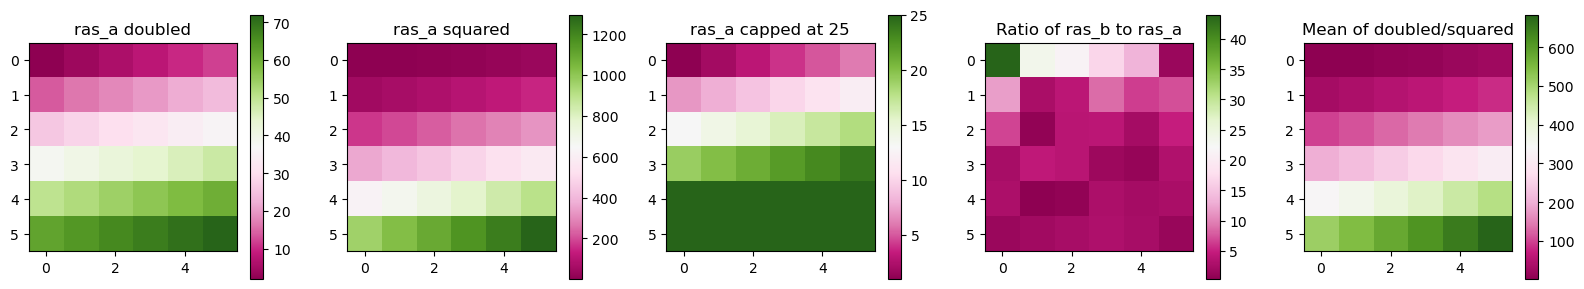

In [16]:
fig, axs = plt.subplots(1,5, figsize=(16,3))
plot0 = axs[0].imshow(X2, cmap="PiYG")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_a doubled")
plot1 = axs[1].imshow(Sq, cmap="PiYG")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_a squared")
plot2 = axs[2].imshow(ras_a_cap, cmap="PiYG")
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("ras_a capped at 25")
plot3 = axs[3].imshow(ratio, cmap="PiYG")
fig.colorbar(plot3, ax=axs[3])
axs[3].set_title("Ratio of ras_b to ras_a")
plot4 = axs[4].imshow(mean, cmap="PiYG")
fig.colorbar(plot4, ax=axs[4])
axs[4].set_title("Mean of doubled/squared")
plt.tight_layout()

In [17]:
ndvi_diff_array = ndvi_summer_array - ndvi_winter_array

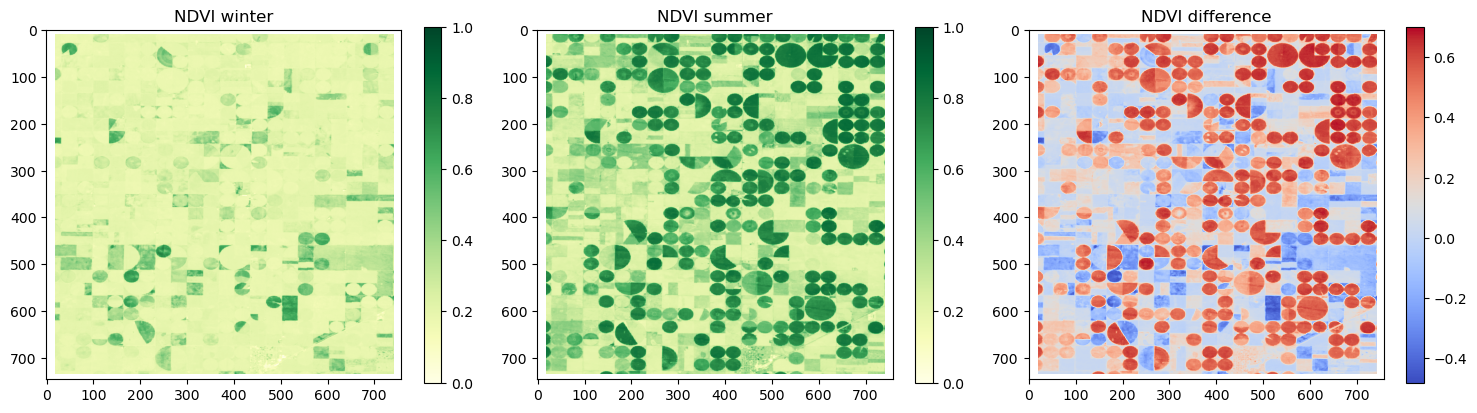

In [18]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
plot0 = axs[0].imshow(ndvi_winter_array, cmap="YlGn", clim=(0,1))
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("NDVI winter")
plot1 = axs[1].imshow(ndvi_summer_array, cmap="YlGn",  clim=(0,1))
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("NDVI summer")
plot2 = axs[2].imshow(ndvi_diff_array, cmap="coolwarm")
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("NDVI difference")
plt.tight_layout()

## <span style="color:blue">Local:</span> Reclassify array data
Reclassification allows to reassign one or more values in a raster dataset to new output values.

In [19]:
reclassified = ras_a.copy()
reclassified[(reclassified > 0) & (reclassified <= 12)] = 1
reclassified[(reclassified > 12) & (reclassified <= 24)] = 2
reclassified[(reclassified > 24) & (reclassified <= 37)] = 3

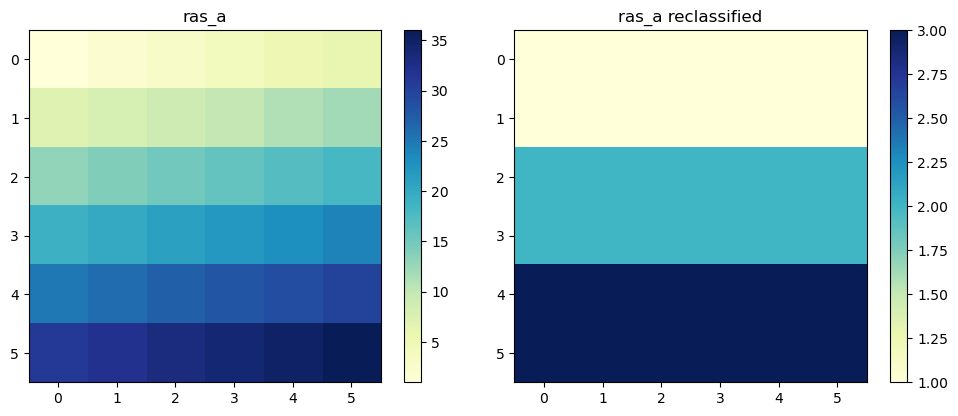

In [20]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
plot0 = axs[0].imshow(ras_a, cmap="YlGnBu")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_a")
plot1 = axs[1].imshow(reclassified, cmap="YlGnBu")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_a reclassified")
plt.tight_layout()

## <span style="color:blue">Focal:</span> Resample to a coarser resolution

In [21]:
scale_factor = 1/2
with rasterio.open("./data-module-3/ras_a.tif") as dataset:
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * scale_factor),
            int(dataset.width * scale_factor)
        ),
        resampling=Resampling.nearest
    )
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
aggregated = data[0]

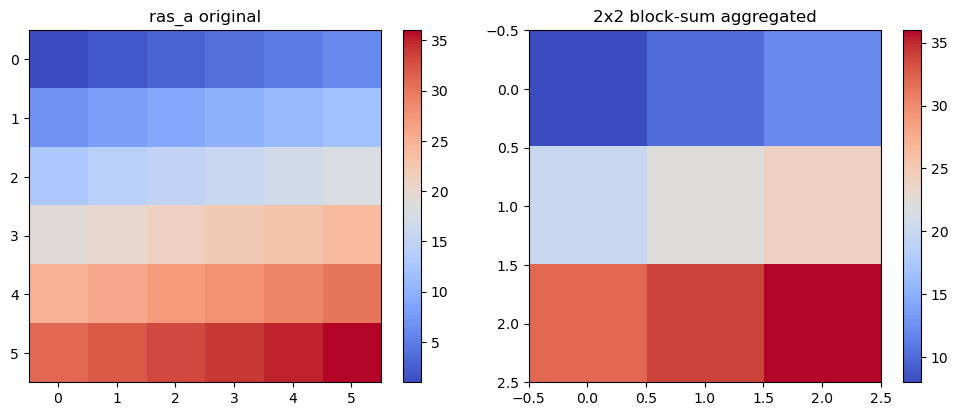

In [22]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
plot0 = axs[0].imshow(ras_a, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_a original")
plot1 = axs[1].imshow(aggregated, cmap="coolwarm")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("2x2 block-sum aggregated")
plt.tight_layout()

In [23]:
scale_factor = 1/10
with rasterio.open("./data-module-3/ndvi_summer.tif") as dataset:
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * scale_factor),
            int(dataset.width * scale_factor)
        ),
        resampling=Resampling.nearest
    )
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
aggregated = data[0]

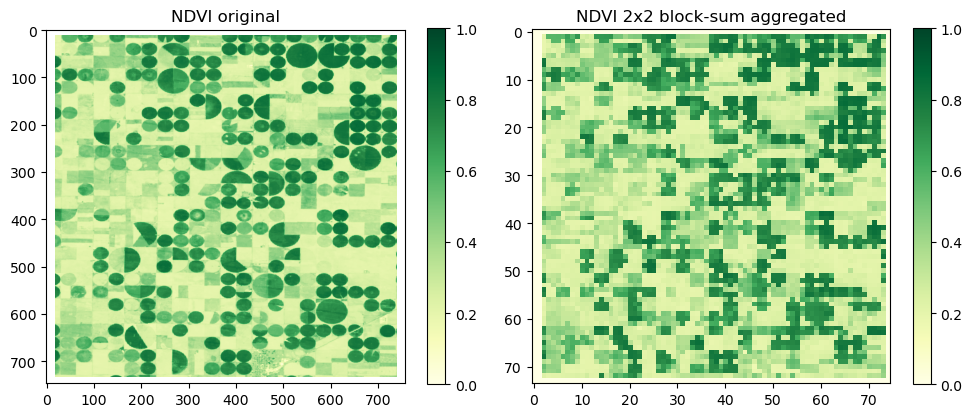

In [24]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
plot0 = axs[0].imshow(ndvi_summer_array,  cmap="YlGn", clim=(0,1))
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("NDVI original")
plot1 = axs[1].imshow(aggregated,  cmap="YlGn", clim=(0,1))
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("NDVI 2x2 block-sum aggregated")
plt.tight_layout()

## <span style="color:blue">Focal:</span> Resample to a higher resolution

In [25]:
scale_factor = 2
with rasterio.open("./data-module-3/ras_a.tif") as dataset:
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * scale_factor),
            int(dataset.width * scale_factor)
        ),
        resampling=Resampling.nearest
    )
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
resampled_n = data[0]

with rasterio.open("./data-module-3/ras_a.tif") as dataset:
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * scale_factor),
            int(dataset.width * scale_factor)
        ),
        resampling=Resampling.bilinear
    )
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
resampled_b = data[0]

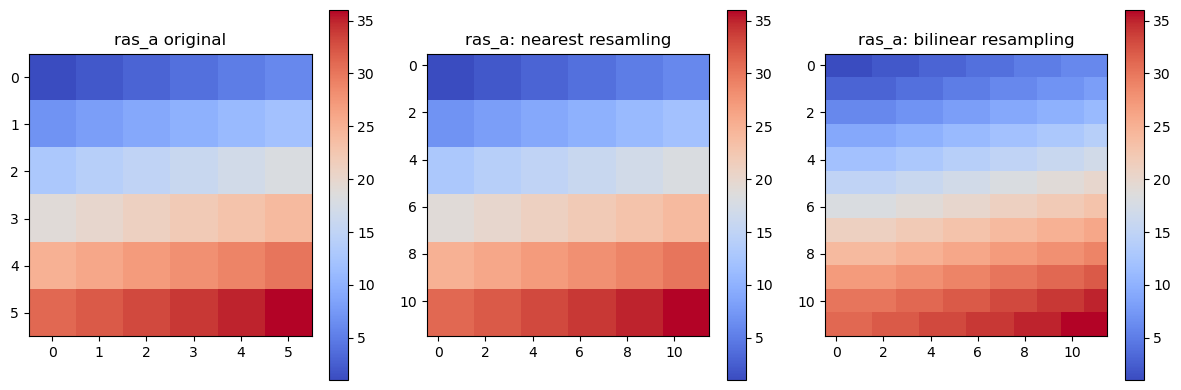

In [26]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
plot0 = axs[0].imshow(ras_a, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_a original")
plot0 = axs[1].imshow(resampled_n, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[1])
axs[1].set_title("ras_a: nearest resamling")
plot1 = axs[2].imshow(resampled_b, cmap="coolwarm")
fig.colorbar(plot1, ax=axs[2])
axs[2].set_title("ras_a: bilinear resampling")
plt.tight_layout()

## <span style="color:blue">Focal:</span> Apply focal statistics
Focal statistics calculates a statistic for input cells with a set of overlapping windows or neighborhoods defined as `kernel`. Please note that we use `xarray` and `xarray-spatial` packages to perfrom these operations.

In [27]:
ras_b_xr =  xr.DataArray(ras_b, dims=["y", "x"], name="b")
ras_b_xr

<xarray.DataArray 'b' (y: 6, x: 6)>
array([[44, 47, 64, 67, 67,  9],
       [83, 21, 36, 87, 70, 88],
       [88, 12, 58, 65, 39, 87],
       [46, 88, 81, 37, 25, 77],
       [72,  9, 20, 80, 69, 79],
       [47, 64, 82, 99, 88, 49]])
Dimensions without coordinates: y, x

In [28]:
ds = xr.Dataset(data_vars=dict(a = (["y", "x"], ras_a), b = (["y", "x"], ras_b)), 
                attrs=dict(description="Data we generated"))
ds

<xarray.Dataset>
Dimensions:  (y: 6, x: 6)
Dimensions without coordinates: y, x
Data variables:
    a        (y, x) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
    b        (y, x) int64 44 47 64 67 67 9 83 21 36 ... 69 79 47 64 82 99 88 49
Attributes:
    description:  Data we generated

In [29]:
kernel1 = circle_kernel(1,1,1)
kernel2 = np.ones([3,3])
focal1 = focal_stats(ras_b_xr, kernel1, stats_funcs=["min"])[0]
focal2 = focal_stats(ras_b_xr, kernel2, stats_funcs=["min"])[0]

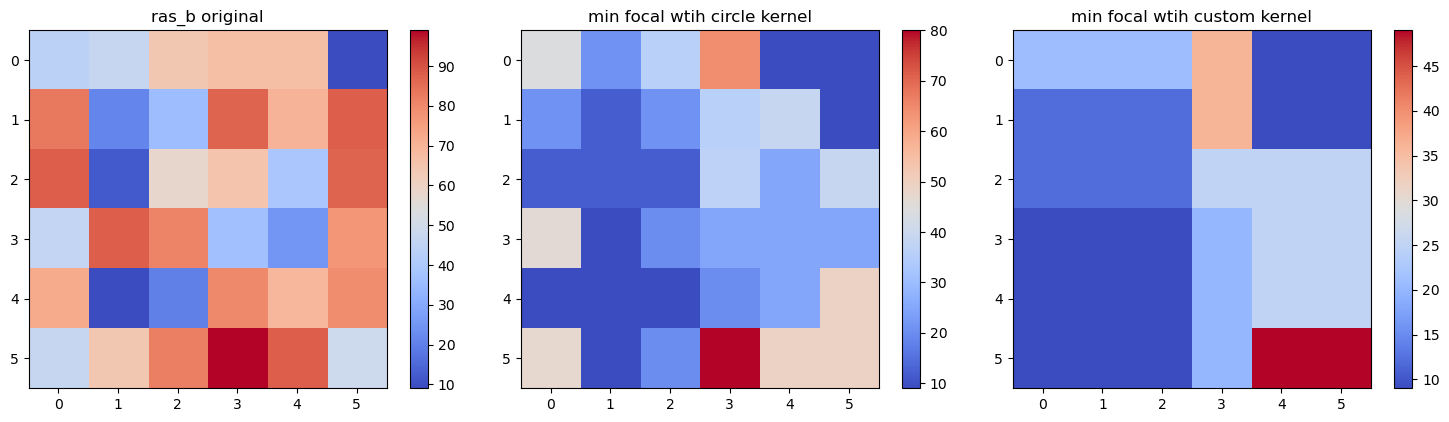

In [30]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
plot0 = axs[0].imshow(ras_b, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_b original")
plot1 = axs[1].imshow(focal1, cmap="coolwarm") 
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("min focal wtih circle kernel")
plot2 = axs[2].imshow(focal2, cmap="coolwarm") 
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("min focal wtih custom kernel")
plt.tight_layout()

In [31]:
ndvi_summer_xr =  xr.DataArray(ndvi_summer_array, dims=["y", "x"], name="ndvi_summer")
kernel = np.ones([15,15])
ndvi_summer_xr_focal = focal_stats(ndvi_summer_xr, kernel, stats_funcs=["mean"])[0]
difference  = ndvi_summer_xr - ndvi_summer_xr_focal

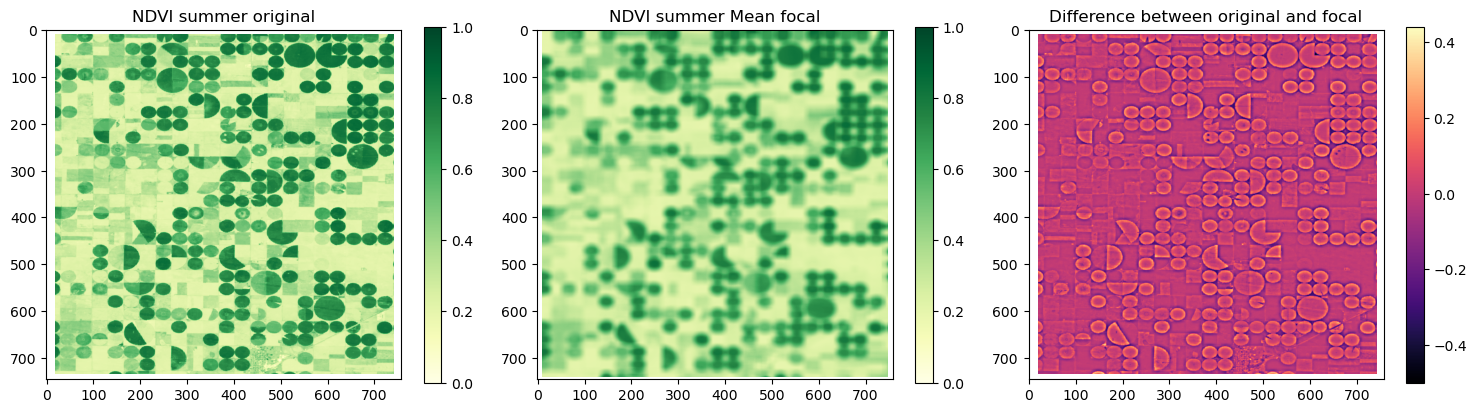

In [32]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
plot0 = axs[0].imshow(ndvi_summer_xr, cmap="YlGn", clim=(0,1))
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("NDVI summer original")
plot1 = axs[1].imshow(ndvi_summer_xr_focal, cmap="YlGn", clim=(0,1)) 
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("NDVI summer Mean focal")
plot2 = axs[2].imshow(difference, cmap="magma") 
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("Difference between original and focal")
plt.tight_layout()

## <span style="color:blue">Zonal:</span> Summarize array by another array
Here we show how to calculate summary statistics for each zone defined by a `zones` dataset, based on `values` array.

Create 'zones' array


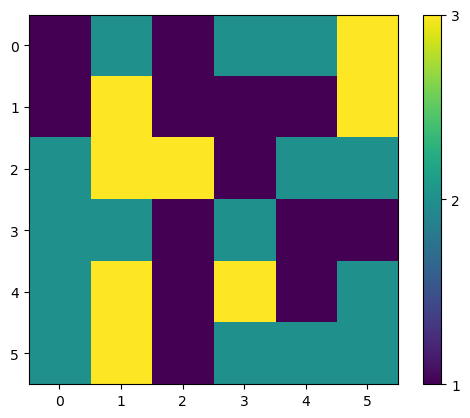

In [33]:
print ("Create 'zones' array")
np.random.seed(0)
categorical = np.random.randint(1,4, size=(6,6))
plt.imshow(categorical)
plt.colorbar(ticks=[1,2,3])

In [34]:
values = xr.DataArray(ras_a)
zones = xr.DataArray(categorical)
stats_df = stats(zones=zones, values=values)
stats_df

,zone,mean,max,min,sum,std,var,count
0,1,16.461538,33.0,1.0,214.0,9.997041,99.940828,13.0
1,2,20.733333,36.0,2.0,311.0,10.914618,119.128889,15.0
2,3,17.625000,32.0,6.0,141.0,9.109576,82.984375,8.0


## Raster-vector interactions: Extract raster by vector geometries

Create arbitrary polygon


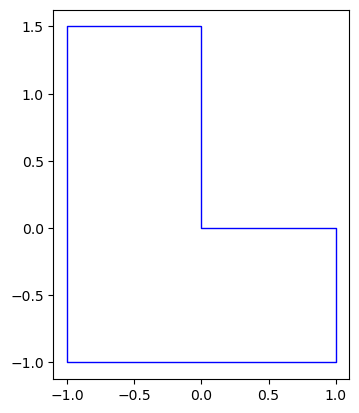

In [35]:
print ("Create arbitrary polygon")
polygon = Polygon([(0, 1.5), (0, 0), (1, 0), (1, -1), (-1, -1), (-1, 1.5)])
gdf = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[polygon])
gdf.plot(facecolor="none", edgecolor="blue")
gdf.to_file("./data-module-3/pol.shp")

Extract raster by polygon


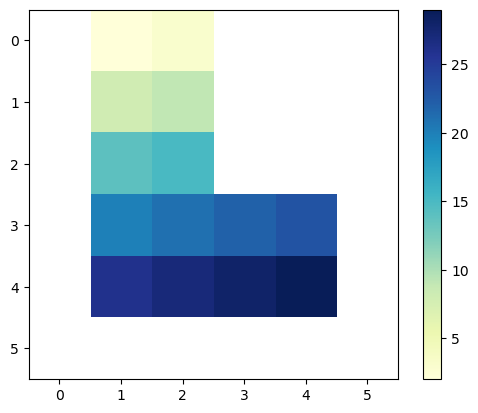

In [36]:
print ("Extract raster by polygon")
with rasterio.open("./data-module-3/ras_a.tif") as src:
    out_img, out_transform = rasterio.mask.mask(dataset=src, shapes=gdf["geometry"], 
                                                nodata=src.nodata, indexes=1, filled=False)
    ras_a_masked = out_img
plt.imshow(ras_a_masked, cmap="YlGnBu")
plt.colorbar()

## <span style="color:blue">Zonal:</span> Summarize by vector geometries (raster-vector interactions)

In [37]:
print ("Summarize raster data by polygon shape")
zs = zonal_stats("./data-module-3/pol.shp", "./data-module-3/ras_a.tif", stats = ["mean",  "count", "sum", "std", "median", "majority", "minority", "range"])
print (zs)

Summarize raster data by polygon shape
[{'mean': 17.642857142857142, 'count': 14, 'sum': 247.0, 'std': 8.885036721984912, 'median': 20.5, 'majority': 2.0, 'minority': 2.0, 'range': 27.0}]


In [38]:
fields_gdf = gpd.read_file("./data-module-3/ag_fields.shp")

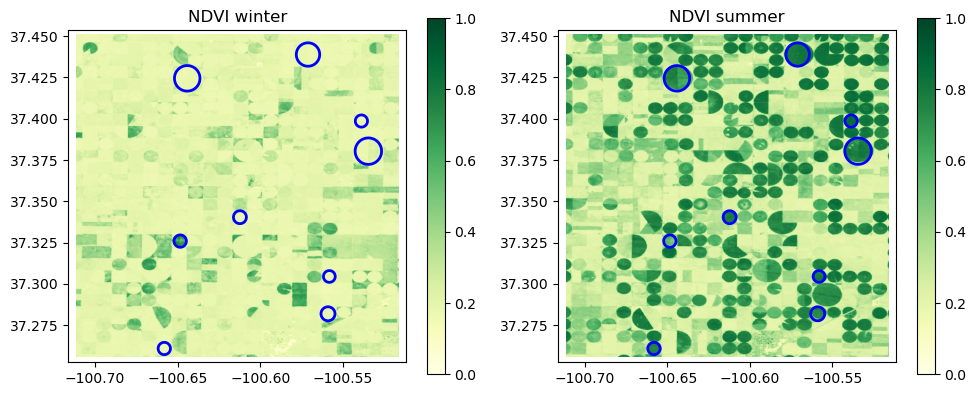

In [39]:
plot_extent = plotting_extent(ndvi_winter_array, ndvi_winter.transform)
fig, axs = plt.subplots(1,2, figsize=(10,4))
fields_gdf.plot(ax=axs[0], facecolor="none", edgecolor="blue", linewidth=2)
plot0 = axs[0].imshow(ndvi_winter_array, cmap="YlGn", clim=(0,1), extent=plot_extent)
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("NDVI winter")
fields_gdf.plot(ax=axs[1], facecolor="none", edgecolor="blue", linewidth=2)
plot1 = axs[1].imshow(ndvi_summer_array, cmap="YlGn",  clim=(0,1), extent=plot_extent)
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("NDVI summer")
plt.tight_layout()

In [40]:
zs = zonal_stats("./data-module-3/ag_fields.shp", "./data-module-3/ndvi_summer.tif", stats = ["mean"])
print (zs)

[{'mean': 0.7933672155179894}, {'mean': 0.6829884708737864}, {'mean': 0.8339374645336254}, {'mean': 0.7283626066625226}, {'mean': 0.5319198784364704}, {'mean': 0.774148682534913}, {'mean': 0.6750924917367789}, {'mean': 0.7470094301863783}, {'mean': 0.750795907685251}]


In [41]:
stats_gdf = fields_gdf.copy()
stats_gdf["ndvi_winter"] = stats_gdf.apply(lambda x: zonal_stats(x.geometry, ndvi_winter_array, affine=ndvi_winter.transform, 
                                                         nodata=ndvi_winter.nodata, stats =["mean"])[0]["mean"], axis=1)
stats_gdf["ndvi_summer"] = stats_gdf.apply(lambda x: zonal_stats(x.geometry, ndvi_summer_array, affine=ndvi_summer.transform, 
                                                         nodata=ndvi_summer.nodata, stats =["mean"])[0]["mean"], axis=1)
stats_gdf

,Id,geometry,ndvi_winter,ndvi_summer
0,0,"POLYGON ((-100.56503 37.43511, -100.56515 37.4...",0.176892,0.793367
1,0,"POLYGON ((-100.63781 37.42002, -100.63794 37.4...",0.180963,0.682988
2,0,"POLYGON ((-100.53562 37.39656, -100.53571 37.3...",0.173494,0.833937
3,0,"POLYGON ((-100.52811 37.37552, -100.52826 37.3...",0.203320,0.728363
4,0,"POLYGON ((-100.64553 37.32350, -100.64564 37.3...",0.656595,0.531920
5,0,"POLYGON ((-100.55534 37.30225, -100.55544 37.3...",0.183888,0.774149
6,0,"POLYGON ((-100.55473 37.28217, -100.55472 37.2...",0.182829,0.675092
7,0,"POLYGON ((-100.65473 37.25917, -100.65481 37.2...",0.170038,0.747009
8,0,"POLYGON ((-100.60895 37.33828, -100.60904 37.3...",0.185868,0.750796


## **Exercises**
Your expercises will draw on datasets from the Spatial Production Allocation Model (SPAM) and Minnesota Geospatial Commons, which have been downloaded, cleaned, transformed, and saved to the directory `./data-module-3/` for this workshop.
### Data
- `spam_H_MAIZ_A_mn.tif` (crop harvested area), `spam_P_MAIZ_A_mn.tif` (crop production) - agricultural indicators at 10x10km grid-cell resolution from MAPSPAM (Spatial Production Allocation Model) data center  https://www.mapspam.info/data/
- `gw_provinces_extra.shp` - Groundwater Provinces of Minnesota derived from  https://gisdata.mn.gov/dataset/geos-groundwater-provinces-mn

**Question 1. Open raster files `spam_H_MAIZ_A_mn.tif` and `spam_P_MAIZ_A_mn.tif` and check their properties: Coordinate Reference System, extent, resolution, NoData, and transform .** 

**Question 2. Read datasets from the previous question as arrays, reset NoData values, and plot them.**

**Question 3. Calculate a ratio of Production raster to Harvested Area to create an array Yield. Find statistics: maximum Yield and its standard deviation.**

**Question 4. Reclassify Yield array by using 3 categories (make your own breaks). Plot both for comparison.**

**Question 5: Resample Production raster to a coarser resolution. Plot both for comparison**

**Question 6. Use focal statistics function on Yield array to create an array which shows the mean yield within 3x3 neighborhood grid cells. Then create a raster map that displays the difference between each grid cell's Yield and "mean" Yield of its neighborhood. Plot the original raster, raster with focal statistics applied, and their difference raster as 3 subplots on the same figure.**

**Question 7. Open `gw_provinces_extra.shp`. Change the CRS of the polygon data to the CRS of the Production raster dataset. Select polygons with `PROVINCE` 1, 2, and 3 for further analysis.** 

**Question 8. Calculate zonal statistics for selected geometries as `sum` of Production raster. Dissolve `production` column by `PROVINCE`.**